In [1]:
import numpy as np
from sklearn import datasets
iris = datasets.load_iris() # アヤメのデータの読み込み
X = iris.data.astype(np.float32) # ４変数を説明変数とする
Y = iris.target # アヤメの品種（３種）を目的変数とする

In [2]:
# アヤメの品種を one-hot vector に変換
Y_ohv = np.zeros(3 * Y.size).reshape(Y.size, 3).astype(np.float32)
for i in range(Y.size):
    Y_ohv[i, Y[i]] = 1.0 # one-hot vector

In [3]:
# 奇数番目のデータを教師データ、偶数番目のデータをテストデータとする
index = np.arange(Y.size)
X_train = X[index[index % 2 != 0], :] # 説明変数（教師データ）
X_test = X[index[index % 2 == 0], :] # 説明変数（テストデータ）
Y_train = Y_ohv[index[index % 2 != 0], :] # 目的変数の one-hot vector （教師データ）
Y_test = Y_ohv[index[index % 2 == 0], :] # 目的変数の one-hot vector （テストデータ）
Y_ans_train = Y[index[index % 2 != 0]] # 目的変数（教師データ）
Y_ans_test = Y[index[index % 2 == 0]] # 目的変数（テストデータ）

In [4]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
Y_train = torch.from_numpy(Y_train).float()
Y_test = torch.from_numpy(Y_test).float()

train = TensorDataset(X_train, Y_train)

train_loader = DataLoader(train, batch_size=10, shuffle=True)

In [5]:
class MLPC(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(MLPC, self).__init__()
        self.l1 = torch.nn.Linear(n_input, n_hidden)
        self.l2 = torch.nn.Linear(n_hidden, n_output)

    def forward(self, x):
        h1 = self.l1(x)
        h2 = torch.sigmoid(h1)
        h3 = self.l2(h2)
        h4 = torch.sigmoid(h3)
        return h4

In [6]:
model = MLPC(4, 3, 3)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

from torch.autograd import Variable
loss_history = []
for epoch in range(5000):
    total_loss = 0
    for x_train, y_train in train_loader:
        x_train = Variable(x_train)
        y_train = Variable(y_train)
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    loss_history.append(total_loss)
    if (epoch +1) % 500 == 0:
        print(epoch + 1, total_loss)

500 1.7699707448482513
1000 1.7264840304851532
1500 1.5750595480203629
2000 1.3672300428152084
2500 1.2094478011131287
3000 1.094790630042553
3500 1.0121220275759697
4000 0.9530835151672363
4500 0.9319839179515839
5000 0.8511377573013306


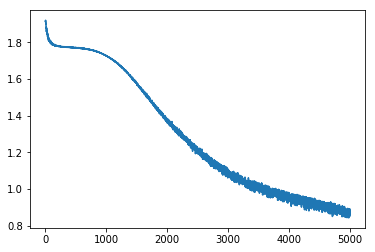

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_history)

In [8]:
Y_pred = model.forward(X_train)
nrow, ncol = Y_pred.data.shape

count = 0
for i in range(nrow):
    cls = np.argmax(Y_pred.data[i, :])
    if cls == Y_ans_train[i]:
        count += 1

print(count, " / ", nrow, " = ", count / nrow)

69  /  75  =  0.92
